# Product Force - The Variant Bunch
February 22nd 2019

Lets read in a ClinVar download, plot some histograms.

In [9]:
import pandas as pd
import numpy as np
from collections import Counter
import json

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Extract genes column.   Some show multiple genes/locations - e.g. "CFTR|LOC11167447".  For now, just take the fires

def extract_first_genes(df_):
    """ Return a list of genes, extracting only one (the first one) per row """
    nrows, ncolumns = df_.shape
    all_genes = df_['Gene(s)']
    single_genes = [g.split('|')[0] for g in all_genes]
    assert len(single_genes) == nrows
    return single_genes

def test_extract_first_genes():
    data = {'Gene(s)': ['GRN|LOC1234', 'CFTR'],
            'Review Status':['None', 'None']}
    df = pd.DataFrame(data)
    genes = extract_first_genes(df)
    print(genes)
    assert len(genes) == 2
    print("test_extract_first_genes: passed.")
    
test_extract_first_genes()

['GRN', 'CFTR']
test_extract_first_genes: passed.


In [12]:
def extract_significance(df_):
    """ Returns a list of significance strings, one for each row """
    nrows, ncolumns = df_.shape
    sigs = df_['Clinical significance (Last reviewed)']
    cleaned_sigs = [s.split('(')[0] for s in sigs]
    return cleaned_sigs

def test_extract_significance():
    data = {'Gene(s)': ['GRN|LOC1234', 'CFTR', 'CTFR'],
            'Clinical significance (Last reviewed)':
                ['Pathogenic(12 May 2010)', 'Pathogenic(21 June 2015)', 'Benign']}
    df = pd.DataFrame(data)
    sigs = extract_significance(df)
    assert len(sigs) == 3
    assert len(set(sigs)) == 2
    print(sigs)
    print("test_extract_significance: passed.")
    
test_extract_significance()
    

['Pathogenic', 'Pathogenic', 'Benign']
test_extract_significance: passed.


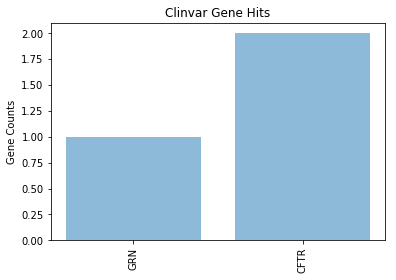

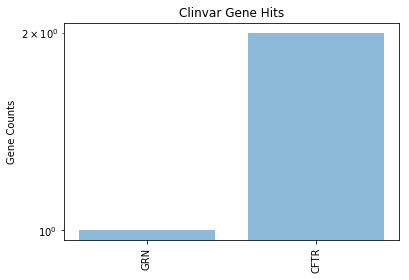

test_plot_gene_histogram: passed.


In [13]:
def plot_gene_histogram(genes, logorlinear='linear'):
    """ Given a list of gene names, plot a histogram of gene counts"""
    assert logorlinear in ('log', 'linear')
    gene_counts = Counter(genes)
    gene_names = gene_counts.keys()
    counts = gene_counts.values()
    bar_pos = np.arange(len(gene_names))

    plt.bar(gene_names, counts, align='center', alpha=0.5)
    plt.xticks(bar_pos, gene_names)
    plt.ylabel('Gene Counts')
    plt.xticks(rotation='vertical')
    plt.yscale(logorlinear)
    plt.title('Clinvar Gene Hits')
    plt.show()
    
def test_plot_gene_histogram():
    test_genes = ["GRN", "CFTR", "CFTR"]
    plot_gene_histogram(test_genes)
    plot_gene_histogram(test_genes, 'log')
    print("test_plot_gene_histogram: passed.")
    
test_plot_gene_histogram()

[[0 1 1 0]
 [1 0 1 1]
 [0 0 1 0]]


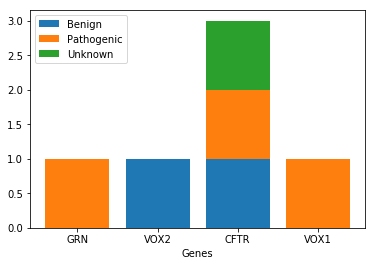

[[0 1 1 0]
 [1 0 1 1]
 [0 0 1 0]]
{'GRN', 'VOX2', 'CFTR', 'VOX1'}
{'Benign', 'Pathogenic', 'Unknown'}


In [14]:
def plot_gene_with_significance_histogram(genes, sigs, logorlinear='linear'):
    """ Given a list of gene names and parallel list of significances, plot a histogram of gene counts
    stacked by significance"""
    assert logorlinear in ('log', 'linear')
    
    gene_sig_counts_zip = Counter(zip(genes, sigs))
    
    gene_set = set(genes)
    sig_set = set(sigs)
    
    # We want a 2D array [sig_ix, gene_ix] of counts
    sig_gene_counts = np.zeros((len(sig_set), len(gene_set)), dtype=int)
    for gix, g in enumerate(gene_set):
        for six, s in enumerate(sig_set):
            sig_gene_counts[six, gix] = gene_sig_counts_zip[(g,s)]
    
    print(sig_gene_counts)
    
    gpos = np.arange(len(gene_set))
    for six,s in enumerate(sig_set):
        plt.bar(gpos, sig_gene_counts[six],
            bottom = np.sum(sig_gene_counts[:six], axis = 0),
            label=s)
    plt.xticks(range(len(gene_set)), list(gene_set))
    plt.xlabel("Genes")
    plt.yscale(logorlinear)
    plt.legend(loc="best")
            
    plt.show()
    
    return sig_gene_counts, gene_set, sig_set
    
            
def test_plot_gene_with_significance_histogram():
    test_genes = ["GRN", "CFTR", "CFTR", "CFTR", "VOX1", "VOX2"]
    test_sigs = ["Pathogenic", "Pathogenic", "Benign", "Unknown", "Pathogenic", "Benign"]
    sig_gene_counts, gene_set, sig_set = plot_gene_with_significance_histogram(test_genes, test_sigs)
    print(sig_gene_counts)
    print(gene_set)
    print(sig_set)
    
test_plot_gene_with_significance_histogram()

In [15]:
def thing_hist_as_json(thing_list):
    """ Return a count histogram in a json format suitable for passing to Alison's front end.  Thing list is e.g.
    a list of names """
    counts = Counter(thing_list)
    jslist = [{'name':key, 'value':counts[key]} for key in counts.keys()]
    return json.dumps(jslist, indent=4, sort_keys=True)
    
def test_thing_hist_as_json():
    test_genes = ["GRN", "CFTR", "CFTR"]
    json = thing_hist_as_json(test_genes)
    print(json)
    print("test_thing_hist_as_json: passed.")
    
test_thing_hist_as_json()   

[
    {
        "name": "GRN",
        "value": 1
    },
    {
        "name": "CFTR",
        "value": 2
    }
]
test_thing_hist_as_json: passed.


In [16]:
def stacked_things_counts_to_json(counts_table, bin_names, stack_names):
    """ Counts table is indexed by [bin, stack] i.e. [gene, sig] """
    rows, cols = counts_table.shape
    assert cols == len(bin_names)
    assert rows == len(stack_names)
    
    f_table = np.asfarray(counts_table)  # json.dumps() only works with float arrays!
    
    jslist = [{'name': bin_names[i], 'value':list(f_table[:,i])} for i in range(len(bin_names))]
    
    print(jslist)
    return json.dumps(jslist, indent=4, sort_keys=True)

def test_stacked_things_counts_to_json():
    counts_table = np.array([[2,3,4,5],
                            [1,2,3,4],
                            [0,2,1,2]])
    print(stacked_things_counts_to_json(counts_table, 
                                        ['GA', 'GB', 'GC', 'GD'], 
                                        ['Benign', 'Unknown', 'Pathological']))
          
test_stacked_things_counts_to_json()



[{'name': 'GA', 'value': [2.0, 1.0, 0.0]}, {'name': 'GB', 'value': [3.0, 2.0, 2.0]}, {'name': 'GC', 'value': [4.0, 3.0, 1.0]}, {'name': 'GD', 'value': [5.0, 4.0, 2.0]}]
[
    {
        "name": "GA",
        "value": [
            2.0,
            1.0,
            0.0
        ]
    },
    {
        "name": "GB",
        "value": [
            3.0,
            2.0,
            2.0
        ]
    },
    {
        "name": "GC",
        "value": [
            4.0,
            3.0,
            1.0
        ]
    },
    {
        "name": "GD",
        "value": [
            5.0,
            4.0,
            2.0
        ]
    }
]


Loading clinvar spreadsheet...


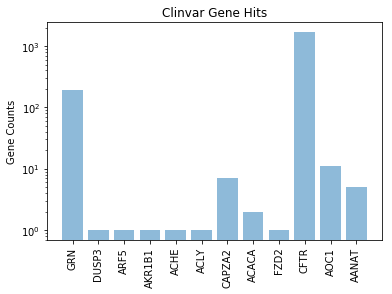

[[  1   0   0   0   0   0   0   0   0   0  16   0]
 [ 11   0   0   0   0   0   0   0   0   0  54   0]
 [  8   0   0   0   0   0   0   0   1   0 145   0]
 [  3   0   0   0   0   0   0   0   0   0  98   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0]
 [ 55   0   0   0   0   0   0   0   0   0 311   0]
 [ 12   0   0   0   0   0   0   0   0   0  19   0]
 [  0   0   0   0   0   0   0   0   0   0  15   0]
 [ 46   1   1   5   1   1   1   1   4   2 417  11]
 [  8   0   0   0   0   0   0   0   0   0  15   0]
 [ 46   0   0   0   0   0   0   0   2   0 564   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   6   0]
 [  0   0   0   0   0   0   0   0   0   0  10   0]]


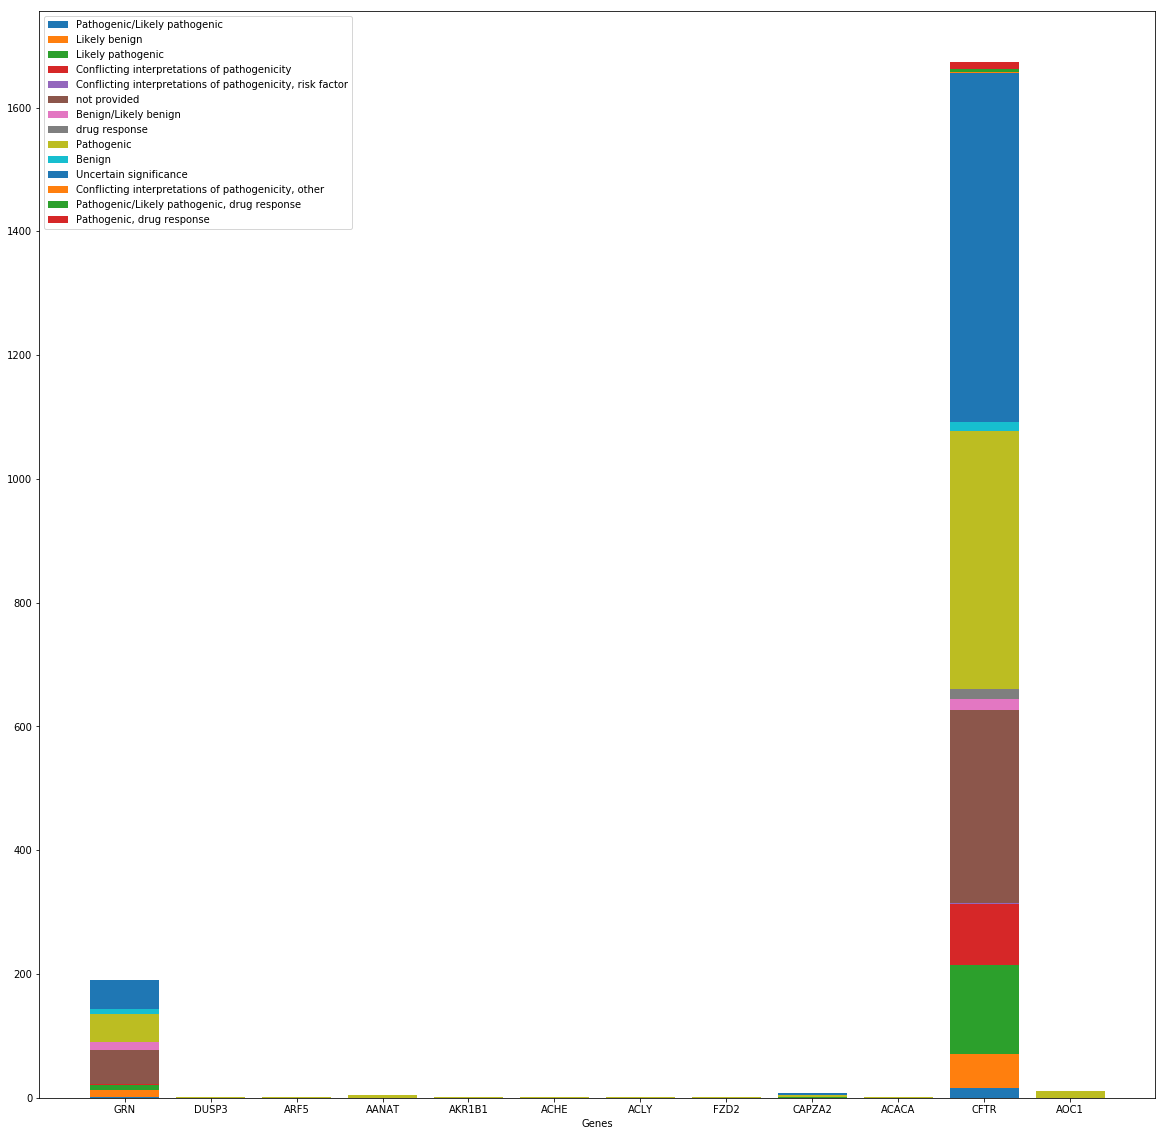

[
    {
        "name": "GRN",
        "value": 190
    },
    {
        "name": "DUSP3",
        "value": 1
    },
    {
        "name": "ARF5",
        "value": 1
    },
    {
        "name": "AKR1B1",
        "value": 1
    },
    {
        "name": "ACHE",
        "value": 1
    },
    {
        "name": "ACLY",
        "value": 1
    },
    {
        "name": "CAPZA2",
        "value": 7
    },
    {
        "name": "ACACA",
        "value": 2
    },
    {
        "name": "FZD2",
        "value": 1
    },
    {
        "name": "CFTR",
        "value": 1673
    },
    {
        "name": "AOC1",
        "value": 11
    },
    {
        "name": "AANAT",
        "value": 5
    }
]
[[  1   0   0   0   0   0   0   0   0   0  16   0]
 [ 11   0   0   0   0   0   0   0   0   0  54   0]
 [  8   0   0   0   0   0   0   0   1   0 145   0]
 [  3   0   0   0   0   0   0   0   0   0  98   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0]
 [ 55   0   0   0   0   0   0   0   0   0 311   0]
 [ 12  

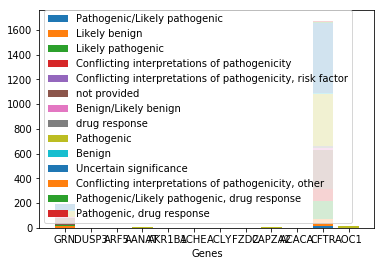

[{'name': 'GRN', 'value': [1.0, 11.0, 8.0, 3.0, 0.0, 55.0, 12.0, 0.0, 46.0, 8.0, 46.0, 0.0, 0.0, 0.0]}, {'name': 'DUSP3', 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'name': 'ARF5', 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'name': 'AANAT', 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'name': 'AKR1B1', 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'name': 'ACHE', 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'name': 'ACLY', 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'name': 'FZD2', 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'name': 'CAPZA2', 'value': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 2.0, 0.0, 0.0, 0.0]}, {'name': 'ACACA', 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [17]:
def main():
    print("Loading clinvar spreadsheet...")
    download_fname = 'clinvar_GRN_OR_CFTR.txt'
    df = pd.read_csv(download_fname, sep='\t')
    # print(df.describe(include='all'))
    
    genes = extract_first_genes(df)
    sigs = extract_significance(df)
    
    plot_gene_histogram(genes, 'log')
    
    plt.figure(figsize=(20,20))
    plot_gene_with_significance_histogram(genes, sigs, 'linear')
    
    json1 = thing_hist_as_json(genes)
    print(json1)
    jsonfile1 = open("histogram_GRN_OR_CFTR.json", 'w')
    jsonfile1.write(json1)
    jsonfile1.close()
    
    sig_gene_counts, gene_set, sig_set = plot_gene_with_significance_histogram(genes, sigs)
    
    json2 = stacked_things_counts_to_json(sig_gene_counts, list(gene_set), list(sig_set))
    print(json2)
    jsonfile2 = open("stacked_GRN_OR_CFTR_Significance.json", 'w')
    jsonfile2.write(json2)
    jsonfile2.close()
    
    

main()